# Otimização de Markowitz

Markowitz foi um grande matemático e pesquisador que desenvolveu a Teoria Moderna do Portfólio, que mudou o mundo das finanças <br>

Nos dias de hoje, todos os conceitos relacionados a risco e retorno que temos deriva dessa teoria. <br>

Um ponto importante que devemos lembrar é que, nessa teoria, a volatilidade e o retorno dos ativos são extremamente levados em conta,<br>
e não os fundamentos em si da companhia, o que pode levar esta otimização a ficar viesada em termos de incluir muito mais os ativos que <br>
recentemente tiveram retornos muito grandes ou vols muito pequenas, o que não quer dizer que vai continuar acontecendo.

--- 
 
### Sharpe

Um conceito importante durante a realização dessa otimização é o do Índice de Sharpre, um outro pesquisador que buscou quantificar <br>
as relações entre o retorno e a volatilidade líquidos de um ativo. (É importante lembrar que no CDI a volatilidade é 0, então não se tira vol).

In [15]:
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt 
import pandas as pd 
from scipy.optimize import minimize # usado para a construção da nossa fronteira eficiente
import matplotlib.ticker as mtick
import mplcyberpunk

### Datas

In [3]:
inicio = dt.date(2017, 1, 1)
fim = dt.date(2023, 12, 31)

### Preços

In [4]:
lista_acoes = ["AAPL", "NKE", "GOOGL", "AMZN"]

precos = yf.download(lista_acoes, inicio, fim)["Adj Close"]

precos

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOGL,NKE
Date,,,,
2017-01-03 00:00:00+00:00,26.921545,37.683498,40.300709,47.627380
2017-01-04 00:00:00+00:00,26.891420,37.859001,40.288738,48.626095
2017-01-05 00:00:00+00:00,27.028172,39.022499,40.550591,48.616940
2017-01-06 00:00:00+00:00,27.329487,39.799500,41.158588,49.395767
2017-01-09 00:00:00+00:00,27.579805,39.846001,41.256844,48.910137
...,...,...,...,...
2023-12-22 00:00:00+00:00,192.868134,153.419998,141.140518,106.760101
2023-12-26 00:00:00+00:00,192.320221,153.410004,141.170441,106.740326
2023-12-27 00:00:00+00:00,192.419830,153.339996,140.023270,105.860870


### Cálculo do retorno logaritmo

In [5]:
retornos = precos.pct_change().apply(lambda x: np.log(1 + x)).dropna() # o dropna tira a primeira linha que não tem retorno

"""O uso do retorno logarítmico lineariza a nossa relação de retorno e,
dessa forma, podemos acumular retorno apenas somando-os

obs: depois voltaremos para o retorno aritmético para que possamos
ter noção da sensibilidade do retorno de fato"""

"""Uma ideia para projetar retornos futuros sem ser pela média passada seria justamente utilizar
a TIR, a taxa interna de rentabilidade lá do Valuation da companhia
"""

media_retornos = retornos.mean()
matriz_cov = retornos.cov()

media_retornos

Ticker
AAPL     0.001116
AMZN     0.000793
GOOGL    0.000705
NKE      0.000462
dtype: float64

## Gerando carteiras aleatórias

In [6]:
num_carteiras = 100_000

tabela_ret_esp = np.zeros(num_carteiras)
tabela_vols_esp = np.zeros(num_carteiras)

tabela_sharpe = np.zeros(num_carteiras)
tabela_pesos = np.zeros((num_carteiras, len(lista_acoes)))

for sample_wallet in range(num_carteiras):

    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos) # normalizing
    tabela_pesos[sample_wallet, :] = pesos

    tabela_ret_esp[sample_wallet] = np.sum(media_retornos * pesos * 252) # anualize by capital market year (cause returns are log)
    tabela_vols_esp[sample_wallet] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos))) #dot é produto de matrizes
    # produto duplo, calculo de volatilidade anualizada ponderada pelos pesos dos ativos, raíz disso é std

    tabela_sharpe[sample_wallet] = tabela_ret_esp[sample_wallet]/tabela_vols_esp[sample_wallet]


### Carteira ótima

In [7]:
sharpe_max = tabela_sharpe.argmax()

tabela_pesos[sharpe_max]

array([0.9363634 , 0.02402623, 0.02917949, 0.01043088])

In [8]:
tabela_ret_esp_arit = np.exp(tabela_ret_esp) - 1

tabela_vols_esp[sharpe_max]

np.float64(0.2943340932848701)

## Gerando fronteira eficiente

Na fronteira eficiente, basicamente queremos juntar os pontos de volatilidades esperadas com o maior retorno para este dados nível de volatilidade!<br>

Geramos então esta seleção de carteiras eficientes e iremos procurar a que possui o maior índice de sharpe

In [9]:
eixo_y_fronteira = np.linspace(tabela_ret_esp_arit.min(),
                               tabela_ret_esp_arit.max(), 50)

# Funções para gerar fronteira

def get_return(peso_teste) -> np.array:
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1

    return retorno

def checar_soma_pesos(peso_teste):

    return np.sum(peso_teste) - 1


def pegar_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))

    return vol


peso_inicial = [1/len(lista_acoes)] * len(lista_acoes)
limites = tuple([(0,1) for ativo in lista_acoes])

eixo_x_fronteira = []

for retorno_possivel in eixo_y_fronteira:
    # pegar melhor vol pra cada retorno possíValueError

    restricoes = ({"type": "eq", "fun": checar_soma_pesos},
                  {"type": "eq", "fun": lambda w: get_return(w) - retorno_possivel})
    
    result = minimize(pegar_vol, peso_inicial, method="SLSQP", bounds=limites,
                      constraints=restricoes)
    
    eixo_x_fronteira.append(result["fun"])

In [10]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2940704879389232
       x: [ 9.216e-01  6.458e-02  1.386e-02  1.670e-18]
     nit: 6
     jac: [ 3.003e-01  2.247e-01  2.048e-01  1.563e-01]
    nfev: 30
    njev: 6

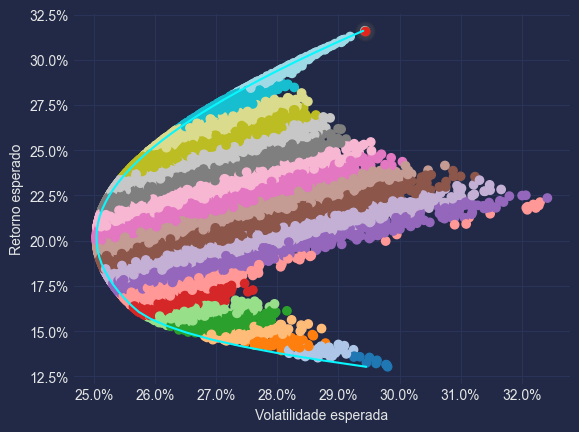

In [20]:
plt.style.use("cyberpunk")

fig, ax = plt.subplots()

ax.scatter(tabela_vols_esp, tabela_ret_esp_arit, c=tabela_sharpe, cmap="tab20")
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")
ax.scatter(tabela_vols_esp[sharpe_max],
           tabela_ret_esp_arit[sharpe_max], c="red")
mplcyberpunk.make_scatter_glow()
ax.plot(eixo_x_fronteira, eixo_y_fronteira)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()